# Text Classification using BERT

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [2]:
import pandas as pd

In [3]:
df = pd.read_csv("spam.csv")
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
df.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

In [5]:
df['Category'].value_counts()

Category
ham     4825
spam     747
Name: count, dtype: int64

In [6]:
747/4825

0.15481865284974095

The dataset contains 15% spam emails and 85% ham emails, this indicates class imbalance

In [7]:
df_spam = df[df['Category'] == 'spam']
df_spam.shape

(747, 2)

In [8]:
df_ham = df[df['Category'] == 'ham']
df_ham.shape

(4825, 2)

In [9]:
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(747, 2)

In [10]:
df_balanced = pd.concat([df_ham_downsampled, df_spam])
df_balanced.shape

(1494, 2)

In [11]:
df_balanced['Category'].value_counts()

Category
ham     747
spam    747
Name: count, dtype: int64

In [12]:
df_balanced['spam'] = df_balanced['Category'].apply(lambda x: 1 if x=='spam' else 0)
df_balanced.sample(5)

,Category,Message,spam
56,spam,Congrats! 1 year special cinema pass for 2 is ...,1
3893,spam,URGENT This is our 2nd attempt to contact U. Y...,1
1497,ham,I'm always on yahoo messenger now. Just send t...,0
1307,spam,Enjoy the jamster videosound gold club with yo...,1
4584,spam,For ur chance to win a £250 wkly shopping spre...,1


In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_balanced['Message'], df_balanced['spam'])

In [14]:
X_train.head()

4041                               I'm at home n ready...
3111    Good Luck! Draw takes place 28th Feb 06. Good ...
3459    Have your lunch and come quickly and open the ...
5336    Sounds better than my evening im just doing my...
1073    Dear U've been invited to XCHAT. This is our f...
Name: Message, dtype: object

In [15]:
X_train.shape, y_train.shape

((1120,), (1120,))

In [16]:
X_test.shape, y_test.shape

((374,), (374,))

### Using BERT model

In [17]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [18]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

In [19]:
get_sentence_embeding([
    "500$ discount. hurry up", 
    "Bhavin, are you up for a volleybal game tomorrow?"]
)

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.84351707, -0.5132727 , -0.88845736, ..., -0.7474888 ,
        -0.75314736,  0.91964495],
       [-0.8720835 , -0.5054398 , -0.94446677, ..., -0.858475  ,
        -0.7174534 ,  0.8808298 ]], dtype=float32)>

#### Get embeding vectors for few sample words. Compare them using cosine similarity

In [20]:
e = get_sentence_embeding([
    "banana", 
    "grapes",
    "mango",
    "jeff bezos",
    "elon musk",
    "bill gates"
])

In [21]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([e[0]], [e[1]])

array([[0.99110866]], dtype=float32)

Here, values near to 1 means they are similar. 0 means they are very different.

In [22]:
cosine_similarity([e[3]], [e[4]])

array([[0.9872034]], dtype=float32)

In [23]:
cosine_similarity([e[0]], [e[3]])

array([[0.8470381]], dtype=float32)

### Build Model

There are two types of models you can build in tensorflow.

(1) Sequential (2) Functional

So far we have built sequential model. But below we will build functional model. More information on these two is here: https://becominghuman.ai/sequential-vs-functional-model-in-keras-20684f766057

In [24]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural Network layers
l = tf.keras.layers.Dropout(0.1, name='dropout')(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs=[l])

In [25]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

In [26]:
len(X_train)

1120

In [27]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [28]:
# Training the model
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
35/35 [==============================] - 224s 6s/step - loss: 0.6355 - accuracy: 0.6589 - precision: 0.6687 - recall: 0.6055
Epoch 2/10
35/35 [==============================] - 212s 6s/step - loss: 0.5083 - accuracy: 0.8223 - precision: 0.8293 - recall: 0.8036
Epoch 3/10
35/35 [==============================] - 281s 8s/step - loss: 0.4410 - accuracy: 0.8625 - precision: 0.8561 - recall: 0.8655
Epoch 4/10
35/35 [==============================] - 490s 14s/step - loss: 0.3918 - accuracy: 0.8884 - precision: 0.8843 - recall: 0.8891
Epoch 5/10
35/35 [==============================] - 710s 20s/step - loss: 0.3621 - accuracy: 0.8714 - precision: 0.8816 - recall: 0.8527
Epoch 6/10
35/35 [==============================] - 367s 10s/step - loss: 0.3358 - accuracy: 0.8973 - precision: 0.8809 - recall: 0.9145
Epoch 7/10
35/35 [==============================] - 221s 6s/step - loss: 0.3188 - accuracy: 0.9036 - precision: 0.8975 - recall: 0.9073
Epoch 8/10
35/35 [===========================

In [29]:
model.evaluate(X_test, y_test)

12/12 [==============================] - 71s 6s/step - loss: 0.2263 - accuracy: 0.9412 - precision: 0.9534 - recall: 0.9340


[0.22633211314678192,
 0.9411764740943909,
 0.9533678889274597,
 0.9340101480484009]

In [30]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

12/12 [==============================] - 71s 6s/step


In [31]:
import numpy as np

y_predicteddicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([0.0155073 , 0.8940224 , 0.01237023, 0.02434373, 0.8739472 ,
       0.1822195 , 0.6265199 , 0.04778511, 0.06607402, 0.07855469,
       0.04023008, 0.74947256, 0.7470892 , 0.4666894 , 0.07684132,
       0.02405998, 0.7936852 , 0.31116882, 0.1250659 , 0.6312428 ,
       0.18775195, 0.72228205, 0.8599886 , 0.10720491, 0.42100823,
       0.67675817, 0.73079216, 0.03107673, 0.681549  , 0.13498048,
       0.9641386 , 0.8367413 , 0.74237007, 0.13618277, 0.10481623,
       0.47368243, 0.1259171 , 0.91782045, 0.91792387, 0.01737829,
       0.33015093, 0.6742986 , 0.05849727, 0.9579888 , 0.04097015,
       0.06120527, 0.9674685 , 0.27870676, 0.8356238 , 0.15259254,
       0.07807981, 0.7801925 , 0.8814942 , 0.05000342, 0.9585624 ,
       0.1304338 , 0.90543544, 0.91980356, 0.6847556 , 0.12368306,
       0.9273961 , 0.83626974, 0.12712313, 0.5796025 , 0.77670443,
       0.1202472 , 0.9373925 , 0.37335333, 0.94132406, 0.9299032 ,
       0.02645416, 0.9305645 , 0.73526347, 0.07205863, 0.75956

In [36]:
threshold = 0.5
y_predicted_class = (y_predicted > threshold).astype(int)

In [37]:
print("y_test:", y_test[:10])
print("y_predicted_class:", y_predicted_class[:10])

y_test: 4826    0
5068    1
5511    0
4273    0
1091    1
1791    0
2915    1
2773    0
3079    0
2858    0
Name: spam, dtype: int64
y_predicted_class: [0 1 0 0 1 0 1 0 0 0]


In [38]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted_class)
cm

array([[168,   9],
       [ 13, 184]], dtype=int64)

Text(50.722222222222214, 0.5, 'Truth')

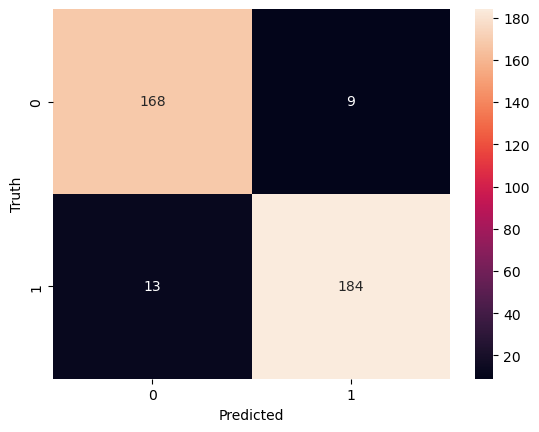

In [39]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [41]:
print(classification_report(y_test, y_predicted_class))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       177
           1       0.95      0.93      0.94       197

    accuracy                           0.94       374
   macro avg       0.94      0.94      0.94       374
weighted avg       0.94      0.94      0.94       374



### Inference

In [42]:
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
model.predict(reviews)

1/1 [==============================] - 2s 2s/step


array([[0.66294646],
       [0.79510516],
       [0.7216178 ],
       [0.17889187],
       [0.08367609]], dtype=float32)

### Using tf serving

tf serving makes model version management and model serving very easy.

In [43]:
model.save("saved_models/1/")

INFO:tensorflow:Assets written to: saved_models/1/assets


INFO:tensorflow:Assets written to: saved_models/1/assets


In [44]:
model.save("saved_models/2/")

INFO:tensorflow:Assets written to: saved_models/2/assets


INFO:tensorflow:Assets written to: saved_models/2/assets


In [45]:
model.save("saved_models/3/")

INFO:tensorflow:Assets written to: saved_models/3/assets


INFO:tensorflow:Assets written to: saved_models/3/assets
